<a id="title_ID"></a>
# JWST Pipeline Validation Notebook:  calwebb_ami3, ami_average

<span style="color:red"> **Instruments Affected**</span>: NIRISS

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction\*](#intro)
<br> [JWST CalWG Algorithm\*](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description\*](#description)
<br> [Data Description\*](#data_descr)
<br> [Imports\*](#imports)
<br> [Loading the Data\*](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Perform Tests or Visualization](#testing) 
<br> [About This Notebook\*](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the validation notebook for the AMI average step. This step averages the results of LG processing from the ami_analyze step for multiple exposures of a given target. It computes a simple average for all 8 components of the “ami” product files from all input exposures. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/ami_average/index.html

Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/ami/ami_average.py


[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm


Confluence page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Average+Fringe+Params


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

* **JWST**: James Webb Space Telescope
* **NIRISS**: Near-Infrared Imager and Slitless Spectrograph
* **AMI**: Aperture Masking Interferometry (NIRISS observing mode)
* **LG**: Lacour-Greenbaum image plane modeling algorithm [(Greenbaum et al. 2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...798...68G/abstract)
* **Interferometric observables**: quantities extracted from interferograms that describe the phase and visibility of the object
* **OIFITS**: Optical Interferometry Flexible Image Transport System; file format used of optical interferometry


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

This test is performed by comparing interferometric observables from multiple exposures averaged together by the pipeline step to those averaged together manually. The data are first calibrated through the Detector1, Image 2, and AMI3 ami_analyze (observable extraction) steps. We use multiple 'ami_analyze.fits' products as the starting point, and produce a single 'amiaveragestep.fits' product. While all eight data extensions of the input files are currently averaged, we are mainly interested in the four observable extensions: closure phase, closure amplitude, visibility phase, and visibility amplitude, as well as the pupil phases and fringe coefficients extensions. We test that each element of the pipeline-averaged arrays of each of these observables is equal to within $1\times 10^{-6}$ to the same element in the manually-averaged array of observables.


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

The data used for this test were created with MIRAGE (Multi-Instrument RAmp GEnerator). The data set contains simulated observations of **AB Dor** (a known binary system) and **HD-37093** (a suitable calibration star) in filter F480M at four primary dither positions. These simulations do not contain bad pixels. For this test, we use two exposures of AB Dor at dither positions 2 and 3, which are cropped to 35 x 35 pixels. 


Outputs of any of the three AMI3 pipeline steps have the following structure:
1. FIT: a 2D image of the fitted model
2. RESID: a 2D image of the fit residuals
3. CLOSURE_AMP: table of closure amplitudes
4. CLOSURE_PHA: table of closure phases
5. FRINGE_AMP: table of fringe amplitudes
6. FRINGE_PHA: table of fringe phases
7. PUPIL_PHA: table of pupil phases
8. SOLNS: table of fringe coefficients

**Note:** Observations at different dither positions are trimmed to different dimensions depending on their location on the SUB80 detector subarray, and the AMI3 pipeline currently crashes if input files have image extensions with different dimensions. Therefore we must currently make sure that the 'FIT' and 'RESID' extensions of the input files have the same dimensions before averaging.


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

[Top of Page](#title_ID)

In [1]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj


## If Desired, set up CRDS to use a local cache

By default, the notebook template environment sets up its CRDS cache (the "CRDS_PATH" environment variable) in /grp/crds/cache. However, if the notebook is running on a local machine without a fast and reliable connection to central storage, it makes more sense to put the CRDS cache locally. Currently, the cell below offers several options, and will check the supplied boolean variables one at a time until one matches.

* if `use_local_crds_cache` is False, then the CRDS cache will be kept in /grp/crds/cache
* if `use_local_crds_cache` is True, the CRDS cache will be kept locally
  * if `crds_cache_tempdir` is True, the CRDS cache will be kept in the temporary directory
  * if `crds_cache_notebook_dir` is True, the CRDS cache will be kept in the same directory as the notebook.
  * if `crds_cache_home` is True, the CRDS cache will be kept in $HOME/crds/cache
  * if `crds_cache_custom_dir` is True, the CRDS cache will be kept in whatever is stored in the 
    `crds_cache_dir_name` variable.

If the above cell (creating a temporary directory) is not run, then setting `crds_cache_tempdir` to True will store the CRDS cache in the notebook's directory (the same as setting `crds_cache_notebook_dir` to True).

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports"></a>
# Imports

* os for interacting with the operating system
* numpy for array handling
* astropy.io for opening fits files
* jwst.datamodels for building model for JWST Pipeline
* jwst.pipeline to run Detector1, Image1 pipelines on test data
* jwst.ami to run AmiAnalyzeStep, AmiAverageStep
* matplotlib.pyplot.plt to generate plots
* ci_watson.artifactory_helpers.get_bigdata for downloading test data
* glob for pathname expansion

[Top of Page](#title_ID)

In [3]:
import os
import numpy as np
from astropy.io import fits
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline, Image2Pipeline
from jwst.ami import AmiAnalyzeStep, AmiAverageStep
import matplotlib.pyplot as plt
from ci_watson.artifactory_helpers import get_bigdata
import glob

<a id="data_load"></a>
# Loading the Data

Load the data from Artifactory (for internal use only)

[Top of Page](#title_ID)

In [4]:

# Get uncalibrated data files
datafiles = []
file = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jw01093001001_01101_00006_nis_uncal.fits')
datafiles.append(file)
file = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jw01093001001_01101_00007_nis_uncal.fits')
datafiles.append(file)

# Get non-standard reference files and AMI3 config file
superbiasfile = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jwst_niriss_superbias_sim.fits')
darkfile = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jwst_niriss_dark_sub80_sim.fits')

flatfieldfile = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jwst_niriss_flat_general.fits')
ami_config = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'ami_analyze.cfg')

# Run Detector1, Image2, ami_analyze

Start with `uncal.fits` files and run the Detector1 pipeline, skipping the IPC correction and overriding the dark and superbias reference files (necessary because of simulations generated without bad pixels).

Then run the Image2 pipeline, skipping the photometry and resample steps, and using a non-default flat field reference file, to produce `cal.fits` products.

Then run the AMI3 ami_analyze step on each `cal.fits` file.

In [5]:
# Modify a keyword in each data file: only necessary for now
for fn in datafiles:
    with datamodels.open(fn) as model:
        model.meta.dither.dither_points = int(model.meta.dither.dither_points)
        model.save(fn)

In [6]:
# Run Detector1, Image 2 pipelines, run ami_analyze on cropped data
odir = os.getcwd()
print('All output files will be saved to %s' % odir)

for df in datafiles:
    result1 = Detector1Pipeline()
    result1.superbias.override_superbias = superbiasfile
    result1.dark_current.override_dark = darkfile
    result1.ipc.skip = True
    result1.save_results = True
    result1.output_dir = odir
    result1.run(df)
            
    df_rate = os.path.join(odir,os.path.basename(df.replace('uncal','rate')))
    result2 = Image2Pipeline()        
    result2.flat_field.override_flat = flatfieldfile
    result2.photom.skip = True
    result2.resample.skip = True
    result2.save_results = True
    result2.output_dir = odir
    result2.run(df_rate)

    df_rateints = os.path.join(odir,os.path.basename(df.replace('uncal','rateints')))
    result3 = Image2Pipeline()
    result3.flat_field.override_flat = flatfieldfile
    result3.photom.skip = True
    result3.resample.skip = True
    result3.save_results = True
    result3.output_dir = odir
    result3.run(df_rateints)        
    
    df_cal = os.path.join(odir,os.path.basename(df.replace('uncal','cal')))
    print("Generated calibrated files", df_cal)  

    #Run ami_analyze on _cal.fits files
    result4 = AmiAnalyzeStep.call(df_cal, config_file='ami_analyze.cfg',output_dir=odir, save_results=True)

2022-01-27 13:49:38,991 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-01-27 13:49:38,994 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-01-27 13:49:38,996 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-01-27 13:49:38,997 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-01-27 13:49:38,999 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-01-27 13:49:39,001 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-01-27 13:49:39,002 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-01-27 13:49:39,004 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-01-27 13:49:39,007 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-01-27 13:49:39,009 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-01-27 13:49:39,010 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-01-27 13:49:39,012 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-01-27 13:49:39,013 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-01-27 13:49:39,014 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-01-27 13:49:39,016 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-01-27 13:49:39,017 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-01-27 13:49:39,020 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


All output files will be saved to /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj


2022-01-27 13:49:39,202 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_uncal.fits',).


2022-01-27 13:49:39,213 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'inp

2022-01-27 13:49:39,285 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01093001001_01101_00006_nis_uncal.fits' reftypes = ['gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'trapdensity', 'trappars']


2022-01-27 13:49:39,525 - stpipe.Detector1Pipeline - INFO - Override for DARK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_dark_sub80_sim.fits'.


2022-01-27 13:49:39,527 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-01-27 13:49:39,529 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-01-27 13:49:39,532 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-01-27 13:49:39,534 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-01-27 13:49:39,536 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits'.


2022-01-27 13:49:39,538 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-01-27 13:49:39,540 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-01-27 13:49:39,540 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-01-27 13:49:39,541 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-01-27 13:49:39,543 - stpipe.Detector1Pipeline - INFO - Override for SUPERBIAS reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_superbias_sim.fits'.


2022-01-27 13:49:39,544 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-01-27 13:49:39,547 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-01-27 13:49:39,549 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-01-27 13:49:39,763 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:49:39,766 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:49:39,820 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-01-27 13:49:39,821 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-01-27 13:49:39,824 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-01-27 13:49:39,964 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:49:39,966 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:49:39,989 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-01-27 13:49:40,894 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-01-27 13:49:40,908 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-01-27 13:49:41,052 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:49:41,054 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:49:41,075 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-01-27 13:49:41,864 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-27 13:49:41,908 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-01-27 13:49:41,939 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-01-27 13:49:41,941 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-01-27 13:49:41,947 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-01-27 13:49:42,095 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:49:42,097 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:49:42,098 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-01-27 13:49:42,100 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-01-27 13:49:42,294 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:49:42,295 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:49:42,307 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_superbias_sim.fits


2022-01-27 13:49:42,500 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-01-27 13:49:42,664 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:49:42,666 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-01-27 13:49:42,676 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-01-27 13:49:42,677 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-01-27 13:49:42,678 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-01-27 13:49:42,678 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2022-01-27 13:49:42,679 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-01-27 13:49:44,895 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-01-27 13:49:45,048 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:49:45,050 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:49:45,073 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-01-27 13:49:47,026 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-27 13:49:47,066 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data


2022-01-27 13:49:47,120 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-01-27 13:49:47,253 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:49:47,255 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-01-27 13:50:12,860 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_trapsfilled.fits


2022-01-27 13:50:12,869 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-01-27 13:50:13,052 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:50:13,054 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'dark_output': None}


2022-01-27 13:50:13,064 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_dark_sub80_sim.fits


2022-01-27 13:50:13,135 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=65, ngroups=5, nframes=1, groupgap=0


2022-01-27 13:50:13,137 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=800, nframes=1, groupgap=0


2022-01-27 13:50:13,192 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-01-27 13:50:13,292 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:50:13,293 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-01-27 13:50:13,303 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-01-27 13:50:13,324 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-01-27 13:50:13,886 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits


2022-01-27 13:50:14,304 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2022-01-27 13:50:14,340 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-01-27 13:50:14,341 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-01-27 13:50:14,353 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-01-27 13:50:14,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-01-27 13:50:14,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 107 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,378 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-01-27 13:50:14,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 93 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,386 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-01-27 13:50:14,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 92 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-01-27 13:50:14,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 107 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,400 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2022-01-27 13:50:14,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 93 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2022-01-27 13:50:14,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 102 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2022-01-27 13:50:14,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 138 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,420 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2022-01-27 13:50:14,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 78 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2022-01-27 13:50:14,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 88 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,431 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2022-01-27 13:50:14,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 101 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:


2022-01-27 13:50:14,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 114 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 12:


2022-01-27 13:50:14,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 130 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 13:


2022-01-27 13:50:14,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 89 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,458 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 14:


2022-01-27 13:50:14,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 94 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,464 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 15:


2022-01-27 13:50:14,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 111 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,471 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 16:


2022-01-27 13:50:14,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 91 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 17:


2022-01-27 13:50:14,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 94 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,484 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 18:


2022-01-27 13:50:14,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 96 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,490 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 19:


2022-01-27 13:50:14,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 103 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,497 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 20:


2022-01-27 13:50:14,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 106 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,503 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 21:


2022-01-27 13:50:14,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 97 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 22:


2022-01-27 13:50:14,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 102 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,515 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:


2022-01-27 13:50:14,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 91 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,521 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:


2022-01-27 13:50:14,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 105 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,528 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:


2022-01-27 13:50:14,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 97 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,534 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 26:


2022-01-27 13:50:14,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 87 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 27:


2022-01-27 13:50:14,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 93 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 28:


2022-01-27 13:50:14,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 102 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 29:


2022-01-27 13:50:14,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 97 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,559 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 30:


2022-01-27 13:50:14,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 123 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 31:


2022-01-27 13:50:14,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 90 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 32:


2022-01-27 13:50:14,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 167 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 33:


2022-01-27 13:50:14,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 76 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,586 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 34:


2022-01-27 13:50:14,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 90 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,592 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 35:


2022-01-27 13:50:14,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 106 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 36:


2022-01-27 13:50:14,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 96 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,605 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 37:


2022-01-27 13:50:14,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 94 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 38:


2022-01-27 13:50:14,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 90 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,617 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 39:


2022-01-27 13:50:14,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 102 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,624 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 40:


2022-01-27 13:50:14,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 80 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,629 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 41:


2022-01-27 13:50:14,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 107 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,636 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 42:


2022-01-27 13:50:14,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 93 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 43:


2022-01-27 13:50:14,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 159 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,650 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 44:


2022-01-27 13:50:14,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 78 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,656 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 45:


2022-01-27 13:50:14,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 100 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,662 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 46:


2022-01-27 13:50:14,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 93 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 47:


2022-01-27 13:50:14,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 96 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 48:


2022-01-27 13:50:14,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 106 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 49:


2022-01-27 13:50:14,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 161 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 50:


2022-01-27 13:50:14,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 99 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,695 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 51:


2022-01-27 13:50:14,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 166 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 52:


2022-01-27 13:50:14,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 153 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,713 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 53:


2022-01-27 13:50:14,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 81 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,719 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 54:


2022-01-27 13:50:14,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 125 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 55:


2022-01-27 13:50:14,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 92 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 56:


2022-01-27 13:50:14,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 91 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,738 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 57:


2022-01-27 13:50:14,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 92 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 58:


2022-01-27 13:50:14,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 79 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,750 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 59:


2022-01-27 13:50:14,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 111 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 60:


2022-01-27 13:50:14,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 124 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,764 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 61:


2022-01-27 13:50:14,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 82 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 62:


2022-01-27 13:50:14,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 92 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 63:


2022-01-27 13:50:14,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 89 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,781 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 64:


2022-01-27 13:50:14,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 104 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,788 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 65:


2022-01-27 13:50:14,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 122 pixels with at least one CR and at least four groups


2022-01-27 13:50:14,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:50:14,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:50:14,795 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.441651 sec


2022-01-27 13:50:14,797 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 1.494377


2022-01-27 13:50:14,802 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-01-27 13:50:14,939 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:50:14,941 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-01-27 13:50:14,974 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits


2022-01-27 13:50:15,001 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-01-27 13:50:15,028 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-01-27 13:50:15,029 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-01-27 13:50:15,030 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-01-27 13:50:15,031 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-01-27 13:50:16,408 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-01-27 13:50:16,409 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 65


2022-01-27 13:50:16,487 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-01-27 13:50:16,597 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:50:16,599 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:50:16,641 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-01-27 13:50:16,642 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-01-27 13:50:16,647 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-01-27 13:50:16,737 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00006_nis_uncal.fits>,).


2022-01-27 13:50:16,739 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:50:16,784 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-01-27 13:50:16,785 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-01-27 13:50:16,789 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-01-27 13:50:16,853 - stpipe.Detector1Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_rateints.fits


2022-01-27 13:50:16,854 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-01-27 13:50:16,902 - stpipe.Detector1Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_rate.fits


2022-01-27 13:50:16,904 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-01-27 13:50:16,908 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-01-27 13:50:16,910 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-01-27 13:50:16,912 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-01-27 13:50:16,913 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-01-27 13:50:16,915 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-01-27 13:50:16,917 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-01-27 13:50:17,007 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_rate.fits',).


2022-01-27 13:50:17,020 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': F

2022-01-27 13:50:17,053 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01093001001_01101_00006_nis_rate.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-01-27 13:50:17,058 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-01-27 13:50:17,059 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-01-27 13:50:17,060 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-01-27 13:50:17,061 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-01-27 13:50:17,063 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_distortion_0011.asdf'.


2022-01-27 13:50:17,068 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-01-27 13:50:17,068 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-01-27 13:50:17,069 - stpipe.Image2Pipeline - INFO - Override for FLAT reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_flat_general.fits'.


2022-01-27 13:50:17,071 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-01-27 13:50:17,072 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-01-27 13:50:17,073 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-01-27 13:50:17,074 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-01-27 13:50:17,075 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-01-27 13:50:17,075 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-01-27 13:50:17,076 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-01-27 13:50:17,076 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-01-27 13:50:17,078 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-01-27 13:50:17,078 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-01-27 13:50:17,078 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-01-27 13:50:17,079 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-01-27 13:50:17,080 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-01-27 13:50:17,081 - stpipe.Image2Pipeline - INFO - Processing product /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis


2022-01-27 13:50:17,081 - stpipe.Image2Pipeline - INFO - Working on input /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_rate.fits ...


2022-01-27 13:50:17,311 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(80, 80) from jw01093001001_01101_00006_nis_rate.fits>,).


2022-01-27 13:50:17,314 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-27 13:50:17,593 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  82.184802918 -65.447631955 82.188126278 -65.448109550 82.189252084 -65.446733854 82.185928722 -65.446256320


2022-01-27 13:50:17,595 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  82.184802918 -65.447631955 82.188126278 -65.448109550 82.189252084 -65.446733854 82.185928722 -65.446256320


2022-01-27 13:50:17,595 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-01-27 13:50:17,639 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-01-27 13:50:17,762 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(80, 80) from jw01093001001_01101_00006_nis_rate.fits>,).


2022-01-27 13:50:17,764 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-01-27 13:50:17,879 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_INTERNAL_FLAT does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-27 13:50:17,950 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2022-01-27 13:50:17,973 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-01-27 13:50:18,074 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(80, 80) from jw01093001001_01101_00006_nis_rate.fits>,).


2022-01-27 13:50:18,076 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'inverse': False, 'source_type': None}


2022-01-27 13:50:18,076 - stpipe.Image2Pipeline.photom - INFO - Step skipped.


2022-01-27 13:50:18,078 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-01-27 13:50:18,079 - stpipe.Image2Pipeline - INFO - Finished processing product /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis


2022-01-27 13:50:18,081 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-01-27 13:50:18,188 - stpipe.Image2Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_cal.fits


2022-01-27 13:50:18,189 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-01-27 13:50:18,193 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-01-27 13:50:18,194 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-01-27 13:50:18,196 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-01-27 13:50:18,197 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-01-27 13:50:18,199 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-01-27 13:50:18,200 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-01-27 13:50:18,298 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_rateints.fits',).


2022-01-27 13:50:18,303 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': F

2022-01-27 13:50:18,356 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01093001001_01101_00006_nis_rateints.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-01-27 13:50:18,359 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-01-27 13:50:18,360 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-01-27 13:50:18,360 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-01-27 13:50:18,361 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-01-27 13:50:18,361 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_distortion_0011.asdf'.


2022-01-27 13:50:18,364 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-01-27 13:50:18,365 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-01-27 13:50:18,365 - stpipe.Image2Pipeline - INFO - Override for FLAT reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_flat_general.fits'.


2022-01-27 13:50:18,366 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-01-27 13:50:18,366 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-01-27 13:50:18,367 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-01-27 13:50:18,367 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-01-27 13:50:18,368 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-01-27 13:50:18,368 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-01-27 13:50:18,368 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-01-27 13:50:18,369 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-01-27 13:50:18,369 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-01-27 13:50:18,370 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-01-27 13:50:18,370 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-01-27 13:50:18,371 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-01-27 13:50:18,371 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-01-27 13:50:18,372 - stpipe.Image2Pipeline - INFO - Processing product /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis


2022-01-27 13:50:18,372 - stpipe.Image2Pipeline - INFO - Working on input /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_rateints.fits ...


2022-01-27 13:50:18,516 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00006_nis_rateints.fits>,).


2022-01-27 13:50:18,518 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-27 13:50:18,753 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  82.184802918 -65.447631955 82.188126278 -65.448109550 82.189252084 -65.446733854 82.185928722 -65.446256320


2022-01-27 13:50:18,754 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  82.184802918 -65.447631955 82.188126278 -65.448109550 82.189252084 -65.446733854 82.185928722 -65.446256320


2022-01-27 13:50:18,755 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-01-27 13:50:18,797 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-01-27 13:50:18,893 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00006_nis_rateints.fits>,).


2022-01-27 13:50:18,894 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-01-27 13:50:18,998 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_INTERNAL_FLAT does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-27 13:50:19,074 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2022-01-27 13:50:19,101 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-01-27 13:50:19,195 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00006_nis_rateints.fits>,).


2022-01-27 13:50:19,196 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'inverse': False, 'source_type': None}


2022-01-27 13:50:19,197 - stpipe.Image2Pipeline.photom - INFO - Step skipped.


2022-01-27 13:50:19,199 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-01-27 13:50:19,200 - stpipe.Image2Pipeline - INFO - Finished processing product /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis


2022-01-27 13:50:19,202 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-01-27 13:50:19,318 - stpipe.Image2Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_calints.fits


2022-01-27 13:50:19,319 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-01-27 13:50:19,404 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/config_parser.py:118: ResourceWarning: unclosed file <_io.BufferedReader name='ami_analyze.cfg'>
  return ConfigObj(config_file, raise_errors=True)



2022-01-27 13:50:19,405 - stpipe.ami_analyze - INFO - AmiAnalyzeStep instance created.


2022-01-27 13:50:19,508 - stpipe.ami_analyze - INFO - Step ami_analyze running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_cal.fits',).


2022-01-27 13:50:19,509 - stpipe.ami_analyze - INFO - Step ami_analyze parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'oversample': 3, 'rotation': 0.0, 'psf_offset': '0.0 0.0', 'rotation_search': '-3 3.1 1.'}


2022-01-27 13:50:19,510 - stpipe.ami_analyze - INFO - Oversampling factor =  3


2022-01-27 13:50:19,510 - stpipe.ami_analyze - INFO - Initial rotation guess = 0.0 deg


2022-01-27 13:50:19,511 - stpipe.ami_analyze - INFO - Initial values to use for psf offset = [0.0, 0.0]


Generated calibrated files /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_cal.fits


2022-01-27 13:50:19,591 - stpipe.ami_analyze - INFO - Using filter throughput reference file /grp/crds/cache/references/jwst/jwst_niriss_throughput_0008.fits


2022-01-27 13:50:19,658 - stpipe.ami_analyze - INFO - Initial values to use for rotation search [-3. -2. -1.  0.  1.  2.  3.]


2022-01-27 13:50:30,477 - stpipe.ami_analyze - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis_ami_analyze.fits


2022-01-27 13:50:30,478 - stpipe.ami_analyze - INFO - Step ami_analyze done


2022-01-27 13:50:30,487 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-01-27 13:50:30,488 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-01-27 13:50:30,489 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-01-27 13:50:30,490 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-01-27 13:50:30,491 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-01-27 13:50:30,492 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-01-27 13:50:30,494 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-01-27 13:50:30,495 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-01-27 13:50:30,496 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-01-27 13:50:30,497 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-01-27 13:50:30,498 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-01-27 13:50:30,499 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-01-27 13:50:30,500 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-01-27 13:50:30,501 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-01-27 13:50:30,503 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-01-27 13:50:30,504 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-01-27 13:50:30,505 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-01-27 13:50:30,622 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_uncal.fits',).


2022-01-27 13:50:30,632 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'inp

2022-01-27 13:50:30,700 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01093001001_01101_00007_nis_uncal.fits' reftypes = ['gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'trapdensity', 'trappars']


2022-01-27 13:50:30,710 - stpipe.Detector1Pipeline - INFO - Override for DARK reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_dark_sub80_sim.fits'.


2022-01-27 13:50:30,710 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits'.


2022-01-27 13:50:30,712 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits'.


2022-01-27 13:50:30,715 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits'.


2022-01-27 13:50:30,717 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.


2022-01-27 13:50:30,718 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits'.


2022-01-27 13:50:30,720 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-01-27 13:50:30,720 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-01-27 13:50:30,721 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-01-27 13:50:30,721 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits'.


2022-01-27 13:50:30,724 - stpipe.Detector1Pipeline - INFO - Override for SUPERBIAS reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_superbias_sim.fits'.


2022-01-27 13:50:30,725 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.


2022-01-27 13:50:30,726 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trappars_0002.fits'.


2022-01-27 13:50:30,728 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-01-27 13:50:30,884 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:50:30,886 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:50:30,928 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-01-27 13:50:30,929 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-01-27 13:50:30,931 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-01-27 13:50:31,018 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:50:31,019 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:50:31,040 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits


2022-01-27 13:50:31,398 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-01-27 13:50:31,411 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-01-27 13:50:31,568 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:50:31,570 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:50:31,594 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0012.fits


2022-01-27 13:50:31,699 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-27 13:50:31,747 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-01-27 13:50:31,777 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-01-27 13:50:31,779 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-01-27 13:50:31,786 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-01-27 13:50:32,014 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:50:32,016 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:50:32,017 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-01-27 13:50:32,020 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-01-27 13:50:32,238 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:50:32,240 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:50:32,253 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_superbias_sim.fits


2022-01-27 13:50:32,429 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-01-27 13:50:32,646 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:50:32,648 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-01-27 13:50:32,660 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-01-27 13:50:32,661 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-01-27 13:50:32,661 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-01-27 13:50:32,662 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2022-01-27 13:50:32,662 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-01-27 13:50:35,167 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-01-27 13:50:35,399 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:50:35,401 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:50:35,425 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0014.fits


2022-01-27 13:50:35,605 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword OCCULTING does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-27 13:50:35,653 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data


2022-01-27 13:50:35,712 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-01-27 13:50:35,935 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:50:35,937 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-01-27 13:51:00,744 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_trapsfilled.fits


2022-01-27 13:51:00,753 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-01-27 13:51:01,046 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:51:01,048 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'dark_output': None}


2022-01-27 13:51:01,060 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_dark_sub80_sim.fits


2022-01-27 13:51:01,127 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=65, ngroups=5, nframes=1, groupgap=0


2022-01-27 13:51:01,129 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=800, nframes=1, groupgap=0


2022-01-27 13:51:01,195 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-01-27 13:51:01,398 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:51:01,400 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-01-27 13:51:01,411 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-01-27 13:51:01,428 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-01-27 13:51:01,470 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits


2022-01-27 13:51:01,500 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2022-01-27 13:51:01,536 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-01-27 13:51:01,538 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-01-27 13:51:01,550 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-01-27 13:51:01,565 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-01-27 13:51:01,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 105 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,576 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-01-27 13:51:01,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 145 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,587 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-01-27 13:51:01,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 108 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,595 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-01-27 13:51:01,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 145 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,604 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2022-01-27 13:51:01,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 84 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2022-01-27 13:51:01,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 97 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,618 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2022-01-27 13:51:01,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 156 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2022-01-27 13:51:01,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 101 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2022-01-27 13:51:01,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 95 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2022-01-27 13:51:01,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 64 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:


2022-01-27 13:51:01,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 69 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,654 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 12:


2022-01-27 13:51:01,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 91 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 13:


2022-01-27 13:51:01,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 107 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 14:


2022-01-27 13:51:01,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 94 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 15:


2022-01-27 13:51:01,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 98 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,683 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 16:


2022-01-27 13:51:01,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 93 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,690 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 17:


2022-01-27 13:51:01,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 152 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,699 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 18:


2022-01-27 13:51:01,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 95 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,706 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 19:


2022-01-27 13:51:01,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 104 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,713 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 20:


2022-01-27 13:51:01,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 87 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,719 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 21:


2022-01-27 13:51:01,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 91 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 22:


2022-01-27 13:51:01,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 91 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,733 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:


2022-01-27 13:51:01,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 105 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,740 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:


2022-01-27 13:51:01,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 83 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,747 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:


2022-01-27 13:51:01,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 126 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,755 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 26:


2022-01-27 13:51:01,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 105 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 27:


2022-01-27 13:51:01,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 102 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 28:


2022-01-27 13:51:01,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 89 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 29:


2022-01-27 13:51:01,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 96 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,784 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 30:


2022-01-27 13:51:01,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 132 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 31:


2022-01-27 13:51:01,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 153 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,801 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 32:


2022-01-27 13:51:01,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 83 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 33:


2022-01-27 13:51:01,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 88 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 34:


2022-01-27 13:51:01,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 86 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 35:


2022-01-27 13:51:01,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 90 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,829 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 36:


2022-01-27 13:51:01,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 102 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,836 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 37:


2022-01-27 13:51:01,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 99 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 38:


2022-01-27 13:51:01,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 70 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,850 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 39:


2022-01-27 13:51:01,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 89 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,857 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 40:


2022-01-27 13:51:01,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 69 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,863 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 41:


2022-01-27 13:51:01,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 67 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,869 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 42:


2022-01-27 13:51:01,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 83 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 43:


2022-01-27 13:51:01,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 88 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,883 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 44:


2022-01-27 13:51:01,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 157 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,893 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 45:


2022-01-27 13:51:01,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 98 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,900 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 46:


2022-01-27 13:51:01,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 146 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,910 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 47:


2022-01-27 13:51:01,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 66 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 48:


2022-01-27 13:51:01,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 150 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,926 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 49:


2022-01-27 13:51:01,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 103 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,934 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 50:


2022-01-27 13:51:01,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 80 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 51:


2022-01-27 13:51:01,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 128 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 52:


2022-01-27 13:51:01,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 81 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 53:


2022-01-27 13:51:01,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 109 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,964 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 54:


2022-01-27 13:51:01,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 92 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 55:


2022-01-27 13:51:01,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 86 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 56:


2022-01-27 13:51:01,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 105 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,986 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 57:


2022-01-27 13:51:01,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 100 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:01,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 58:


2022-01-27 13:51:01,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 97 pixels with at least one CR and at least four groups


2022-01-27 13:51:01,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:01,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:02,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 59:


2022-01-27 13:51:02,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 78 pixels with at least one CR and at least four groups


2022-01-27 13:51:02,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:02,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:02,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 60:


2022-01-27 13:51:02,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 105 pixels with at least one CR and at least four groups


2022-01-27 13:51:02,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:02,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:02,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 61:


2022-01-27 13:51:02,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 102 pixels with at least one CR and at least four groups


2022-01-27 13:51:02,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:02,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:02,024 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 62:


2022-01-27 13:51:02,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 81 pixels with at least one CR and at least four groups


2022-01-27 13:51:02,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:02,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:02,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 63:


2022-01-27 13:51:02,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 111 pixels with at least one CR and at least four groups


2022-01-27 13:51:02,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:02,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:02,038 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 64:


2022-01-27 13:51:02,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 105 pixels with at least one CR and at least four groups


2022-01-27 13:51:02,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:02,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:02,046 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 65:


2022-01-27 13:51:02,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 164 pixels with at least one CR and at least four groups


2022-01-27 13:51:02,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2022-01-27 13:51:02,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2022-01-27 13:51:02,055 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.50466 sec


2022-01-27 13:51:02,058 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.647836


2022-01-27 13:51:02,064 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-01-27 13:51:02,275 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:51:02,277 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2022-01-27 13:51:02,313 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits


2022-01-27 13:51:02,345 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_niriss_gain_0006.fits


2022-01-27 13:51:02,379 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-01-27 13:51:02,380 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-01-27 13:51:02,381 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-01-27 13:51:02,382 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-01-27 13:51:03,824 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 5


2022-01-27 13:51:03,825 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 65


2022-01-27 13:51:03,903 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-01-27 13:51:04,125 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:51:04,128 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:51:04,176 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-01-27 13:51:04,177 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-01-27 13:51:04,182 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-01-27 13:51:04,399 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00007_nis_uncal.fits>,).


2022-01-27 13:51:04,401 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj'}


2022-01-27 13:51:04,455 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-01-27 13:51:04,456 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-01-27 13:51:04,461 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-01-27 13:51:04,532 - stpipe.Detector1Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_rateints.fits


2022-01-27 13:51:04,534 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-01-27 13:51:04,587 - stpipe.Detector1Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_rate.fits


2022-01-27 13:51:04,588 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-01-27 13:51:04,593 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-01-27 13:51:04,594 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-01-27 13:51:04,596 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-01-27 13:51:04,598 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-01-27 13:51:04,600 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-01-27 13:51:04,601 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-01-27 13:51:04,829 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_rate.fits',).


2022-01-27 13:51:04,834 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': F

2022-01-27 13:51:04,873 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01093001001_01101_00007_nis_rate.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-01-27 13:51:04,878 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-01-27 13:51:04,878 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-01-27 13:51:04,879 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-01-27 13:51:04,880 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-01-27 13:51:04,880 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_distortion_0011.asdf'.


2022-01-27 13:51:04,883 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-01-27 13:51:04,884 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-01-27 13:51:04,885 - stpipe.Image2Pipeline - INFO - Override for FLAT reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_flat_general.fits'.


2022-01-27 13:51:04,885 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-01-27 13:51:04,886 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-01-27 13:51:04,887 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-01-27 13:51:04,887 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-01-27 13:51:04,888 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-01-27 13:51:04,889 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-01-27 13:51:04,889 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-01-27 13:51:04,890 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-01-27 13:51:04,890 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-01-27 13:51:04,893 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-01-27 13:51:04,893 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-01-27 13:51:04,894 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-01-27 13:51:04,895 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-01-27 13:51:04,896 - stpipe.Image2Pipeline - INFO - Processing product /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis


2022-01-27 13:51:04,897 - stpipe.Image2Pipeline - INFO - Working on input /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_rate.fits ...


2022-01-27 13:51:05,138 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(80, 80) from jw01093001001_01101_00007_nis_rate.fits>,).


2022-01-27 13:51:05,140 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-27 13:51:05,358 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  82.186173907 -65.447829026 82.189497293 -65.448306621 82.190623107 -65.446930925 82.187299721 -65.446453392


2022-01-27 13:51:05,360 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  82.186173907 -65.447829026 82.189497293 -65.448306621 82.190623107 -65.446930925 82.187299721 -65.446453392


2022-01-27 13:51:05,360 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-01-27 13:51:05,405 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-01-27 13:51:05,627 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(80, 80) from jw01093001001_01101_00007_nis_rate.fits>,).


2022-01-27 13:51:05,629 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-01-27 13:51:05,752 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_INTERNAL_FLAT does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-27 13:51:05,830 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2022-01-27 13:51:05,854 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-01-27 13:51:06,074 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(80, 80) from jw01093001001_01101_00007_nis_rate.fits>,).


2022-01-27 13:51:06,076 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'inverse': False, 'source_type': None}


2022-01-27 13:51:06,077 - stpipe.Image2Pipeline.photom - INFO - Step skipped.


2022-01-27 13:51:06,080 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-01-27 13:51:06,081 - stpipe.Image2Pipeline - INFO - Finished processing product /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis


2022-01-27 13:51:06,084 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-01-27 13:51:06,195 - stpipe.Image2Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_cal.fits


2022-01-27 13:51:06,196 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-01-27 13:51:06,201 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-01-27 13:51:06,202 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-01-27 13:51:06,204 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-01-27 13:51:06,206 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-01-27 13:51:06,208 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-01-27 13:51:06,209 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-01-27 13:51:06,427 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_rateints.fits',).


2022-01-27 13:51:06,432 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': F

2022-01-27 13:51:06,491 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01093001001_01101_00007_nis_rateints.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-01-27 13:51:06,494 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-01-27 13:51:06,496 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-01-27 13:51:06,496 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-01-27 13:51:06,497 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-01-27 13:51:06,498 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_distortion_0011.asdf'.


2022-01-27 13:51:06,500 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-01-27 13:51:06,501 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-01-27 13:51:06,502 - stpipe.Image2Pipeline - INFO - Override for FLAT reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jwst_niriss_flat_general.fits'.


2022-01-27 13:51:06,503 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-01-27 13:51:06,504 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-01-27 13:51:06,504 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-01-27 13:51:06,505 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-01-27 13:51:06,505 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-01-27 13:51:06,506 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-01-27 13:51:06,506 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-01-27 13:51:06,507 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-01-27 13:51:06,507 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-01-27 13:51:06,508 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-01-27 13:51:06,508 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-01-27 13:51:06,509 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-01-27 13:51:06,512 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-01-27 13:51:06,513 - stpipe.Image2Pipeline - INFO - Processing product /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis


2022-01-27 13:51:06,513 - stpipe.Image2Pipeline - INFO - Working on input /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_rateints.fits ...


2022-01-27 13:51:06,787 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00007_nis_rateints.fits>,).


2022-01-27 13:51:06,789 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-27 13:51:07,082 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  82.186173907 -65.447829026 82.189497293 -65.448306621 82.190623107 -65.446930925 82.187299721 -65.446453392


2022-01-27 13:51:07,083 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  82.186173907 -65.447829026 82.189497293 -65.448306621 82.190623107 -65.446930925 82.187299721 -65.446453392


2022-01-27 13:51:07,084 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-01-27 13:51:07,131 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-01-27 13:51:07,362 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00007_nis_rateints.fits>,).


2022-01-27 13:51:07,364 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-01-27 13:51:07,489 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_INTERNAL_FLAT does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-27 13:51:07,576 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2022-01-27 13:51:07,605 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-01-27 13:51:07,829 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00007_nis_rateints.fits>,).


2022-01-27 13:51:07,831 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'inverse': False, 'source_type': None}


2022-01-27 13:51:07,833 - stpipe.Image2Pipeline.photom - INFO - Step skipped.


2022-01-27 13:51:07,837 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-01-27 13:51:07,838 - stpipe.Image2Pipeline - INFO - Finished processing product /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis


2022-01-27 13:51:07,841 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-01-27 13:51:07,980 - stpipe.Image2Pipeline - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_calints.fits


2022-01-27 13:51:07,982 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-01-27 13:51:08,123 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/config_parser.py:118: ResourceWarning: unclosed file <_io.BufferedReader name='ami_analyze.cfg'>
  return ConfigObj(config_file, raise_errors=True)



2022-01-27 13:51:08,126 - stpipe.ami_analyze - INFO - AmiAnalyzeStep instance created.


Generated calibrated files /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_cal.fits


2022-01-27 13:51:08,377 - stpipe.ami_analyze - INFO - Step ami_analyze running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_cal.fits',).


2022-01-27 13:51:08,379 - stpipe.ami_analyze - INFO - Step ami_analyze parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'oversample': 3, 'rotation': 0.0, 'psf_offset': '0.0 0.0', 'rotation_search': '-3 3.1 1.'}


2022-01-27 13:51:08,382 - stpipe.ami_analyze - INFO - Oversampling factor =  3


2022-01-27 13:51:08,382 - stpipe.ami_analyze - INFO - Initial rotation guess = 0.0 deg


2022-01-27 13:51:08,383 - stpipe.ami_analyze - INFO - Initial values to use for psf offset = [0.0, 0.0]


2022-01-27 13:51:08,474 - stpipe.ami_analyze - INFO - Using filter throughput reference file /grp/crds/cache/references/jwst/jwst_niriss_throughput_0008.fits


2022-01-27 13:51:08,548 - stpipe.ami_analyze - INFO - Initial values to use for rotation search [-3. -2. -1.  0.  1.  2.  3.]


2022-01-27 13:51:20,212 - stpipe.ami_analyze - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00007_nis_ami_analyze.fits


2022-01-27 13:51:20,215 - stpipe.ami_analyze - INFO - Step ami_analyze done


### Examine the ami_analyze file structure

In [7]:
infiles = glob.glob('*ami_analyze.fits')

for file in infiles:
    fits.info(file)
    print('\n')

Filename: jw01093001001_01101_00006_nis_ami_analyze.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     258   ()      
  1  FIT           1 ImageHDU         9   (35, 35)   float32   
  2  RESID         1 ImageHDU         9   (35, 35)   float32   
  3  CLOSURE_AMP    1 BinTableHDU     12   35R x 1C   [D]   
  4  CLOSURE_PHA    1 BinTableHDU     12   35R x 1C   [D]   
  5  FRINGE_AMP    1 BinTableHDU     12   21R x 1C   [D]   
  6  FRINGE_PHA    1 BinTableHDU     12   21R x 1C   [D]   
  7  PUPIL_PHA     1 BinTableHDU     12   7R x 1C   [D]   
  8  SOLNS         1 BinTableHDU     12   44R x 1C   [D]   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [5953B]   




Filename: jw01093001001_01101_00007_nis_ami_analyze.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     258   ()      
  1  FIT           1 ImageHDU         9   (35, 35)   float32   
  2  RESID         1 ImageHDU         9   (35, 35)   float32   
  3  CLOSURE_AMP    1 BinTableHDU     12   35R x 1C   [D]   
  4  CLOSURE_PHA    1 BinTableHDU     12   35R x 1C   [D]   
  5  FRINGE_AMP    1 BinTableHDU     12   21R x 1C   [D]   
  6  FRINGE_PHA    1 BinTableHDU     12   21R x 1C   [D]   
  7  PUPIL_PHA     1 BinTableHDU     12   7R x 1C   [D]   
  8  SOLNS         1 BinTableHDU     12   44R x 1C   [D]   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [5954B]   


<a id="pipeline"></a>
# Run the AmiAverage Step

Run the AMI3 AmiAverage step on the two 'ami_analyze.fits' files. First, create the base of the output filename from one of the input filenames (the output name will have 'amiaveragestep.fits' appended automatically)

In [8]:
basename = os.path.basename(infiles[0]).split('_ami_analyze', 1)[0]

amiavg = AmiAverageStep.call(infiles, save_results=True, output_file=basename)

2022-01-27 13:51:20,364 - stpipe.AmiAverageStep - INFO - AmiAverageStep instance created.


2022-01-27 13:51:20,590 - stpipe.AmiAverageStep - INFO - Step AmiAverageStep running with args (['jw01093001001_01101_00006_nis_ami_analyze.fits', 'jw01093001001_01101_00007_nis_ami_analyze.fits'],).


2022-01-27 13:51:20,592 - stpipe.AmiAverageStep - INFO - Step AmiAverageStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpoamo4bmj/jw01093001001_01101_00006_nis', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-01-27 13:51:20,863 - stpipe.AmiAverageStep - INFO - Saved model in jw01093001001_01101_00006_nis_amiaveragestep.fits


2022-01-27 13:51:20,864 - stpipe.AmiAverageStep - INFO - Step AmiAverageStep done


<a id="testing"></a>
# Perform Tests or Visualization

Perform the validation tests described previously. Generate plots, tables, diagnostics, etc. 

[Top of Page](#title_ID)

### Load the ami_average product

We will only be using the averaged interferometric observables: closure phase, closure amplitude, fringe phase, and fringe amplitude, as well as the pupil phase and fringe coefficients ('SOLNS' extension). First, define a function to read in all the relevant extensions.

In [9]:
def read_ami(fn):
    with fits.open(fn) as hdu1:
        CA = hdu1['CLOSURE_AMP'].data.astype(np.float64)
        CP = hdu1['CLOSURE_PHA'].data.astype(np.float64)
        FA = hdu1['FRINGE_AMP'].data.astype(np.float64)
        FP = hdu1['FRINGE_PHA'].data.astype(np.float64)
        PP = hdu1['PUPIL_PHA'].data.astype(np.float64)
        soln = hdu1['SOLNS'].data.astype(np.float64)
    return CA, CP, FA, FP, PP, soln

In [10]:
amiavgfile = glob.glob('*amiaveragestep.fits')[0]

CA_pipe, CP_pipe, FA_pipe, FP_pipe, PP_pipe, soln_pipe = read_ami(amiavgfile)


print('%i Closure Phases' % len(CP_pipe))
print('%i Closure Amplitudes' % len(CA_pipe))
print('%i Fringe Phases' % len(FP_pipe))
print('%i Fringe Amplitudes' % len(FA_pipe))
print('%i Pupil Phases' % len(PP_pipe))
print('%i Fringe Coeffs' % len(soln_pipe))

35 Closure Phases
35 Closure Amplitudes
21 Fringe Phases
21 Fringe Amplitudes
7 Pupil Phases
44 Fringe Coeffs


### Manually average observables from input files

Load the observables from each file into lists, and take the mean of the observable arrays across the exposures, preserving the length of each array.

In [11]:
CPs = []
CAs = []
FPs = []
FAs = []
PPs = []
solns = []
for fn in infiles:
    CA, CP, FA, FP, PP, soln = read_ami(fn)
    CAs.append(CA)
    CPs.append(CP)
    FAs.append(FA)
    FPs.append(FP)
    PPs.append(PP)
    solns.append(soln)

CP_man = np.mean(CPs, axis=0)
CA_man = np.mean(CAs, axis=0)
FP_man = np.mean(FPs, axis=0)
FA_man = np.mean(FAs, axis=0)
PP_man = np.mean(PPs, axis=0)
soln_man = np.mean(solns, axis=0)

### Test the agreement

Test if the pipeline-avergaed and manually-averaged observables are equal, to within a tolerance of $1\times 10^{-6}$

In [12]:
rtol=0.0 # relative tolerance
atol=1e-6 # absolute tolerance
print('\n Closure phases:',np.allclose(CP_pipe,CP_man,rtol,atol),'\n',
     'Closure amplitudes:',np.allclose(CA_pipe,CA_man,rtol,atol),'\n',
     'Fringe phases:',np.allclose(FP_pipe,FP_man,rtol,atol),'\n',
     'Fringe amplitudes:',np.allclose(FA_pipe,FA_man,rtol,atol),'\n',
     'Pupil phases:',np.allclose(PP_pipe,PP_man,rtol,atol),'\n',
     'Fringe coefficients:',np.allclose(soln_pipe,soln_man,rtol,atol),'\n',)


 Closure phases: True 
 Closure amplitudes: True 
 Fringe phases: True 
 Fringe amplitudes: True 
 Pupil phases: True 
 Fringe coefficients: True 



### Visualize the difference
Plot the two averaged sets of observables. If the observables were averaged correctly, the points should lie on top of each other:

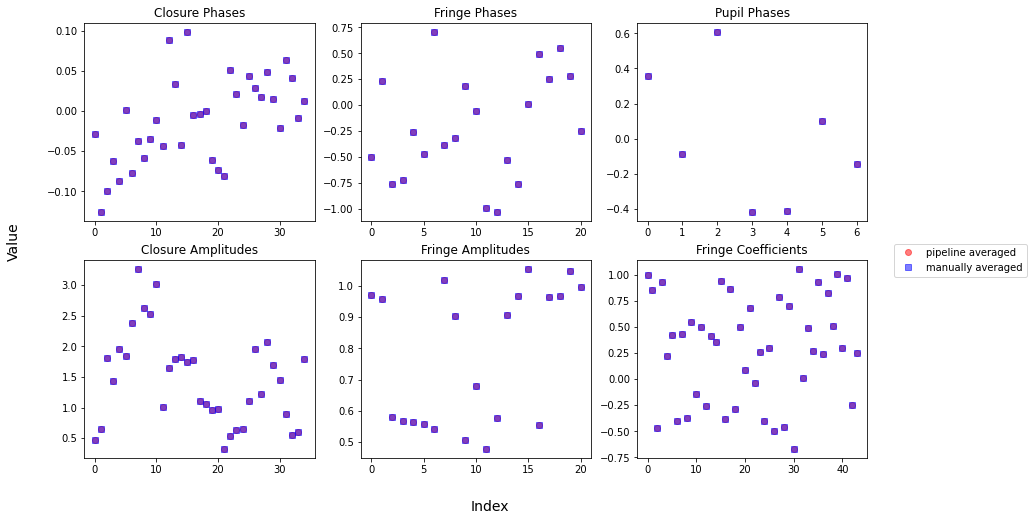

In [13]:
n_closure = np.arange(len(CP_pipe))
n_fringe = np.arange(len(FP_pipe))
n_pup = np.arange(len(PP_pipe))
n_soln = np.arange(len(soln_pipe))

fig, axs = plt.subplots(2,3, figsize=(15,8))
axs[0][0].plot(n_closure,CP_pipe,'ro', alpha=.5, label='pipeline averaged')
axs[0][0].plot(n_closure,CP_man,'bs', alpha=.5, label='manually averaged')
axs[0][0].plot((n_closure,n_closure),(CP_pipe,CP_man),c='black',linewidth=.5)
axs[0][0].set_title('Closure Phases')

axs[0][1].plot(n_fringe,FP_pipe,'ro', alpha=.5)
axs[0][1].plot(n_fringe,FP_man,'bs', alpha=.5)
axs[0][1].plot((n_fringe,n_fringe),(FP_pipe,FP_man),c='black',linewidth=.5)
axs[0][1].set_title('Fringe Phases')

axs[0][2].plot(n_pup,PP_pipe,'ro', alpha=.5)
axs[0][2].plot(n_pup,PP_man,'bs', alpha=.5)
axs[0][2].plot((n_pup,n_pup),(PP_pipe,PP_man),c='black',linewidth=.5)
axs[0][2].set_title('Pupil Phases')

axs[1][0].plot(n_closure,CA_pipe,'ro', alpha=.5)
axs[1][0].plot(n_closure,CA_man,'bs', alpha=.5)
axs[1][0].plot((n_closure,n_closure),(CA_pipe,CA_man),c='black',linewidth=.5)
axs[1][0].set_title('Closure Amplitudes')

axs[1][1].plot(n_fringe,FA_pipe,'ro', alpha=.5)
axs[1][1].plot(n_fringe,FA_man,'bs', alpha=.5)
axs[1][1].plot((n_fringe,n_fringe),(FA_pipe,FA_man),c='black',linewidth=.5)
axs[1][1].set_title('Fringe Amplitudes')

axs[1][2].plot(n_soln,soln_pipe,'ro', alpha=.5)
axs[1][2].plot(n_soln,soln_man,'bs', alpha=.5)
axs[1][2].plot((n_soln,n_soln),(soln_pipe,soln_man),c='black',linewidth=.5)
axs[1][2].set_title('Fringe Coefficients')

fig.text(0.5, 0.04, 'Index', ha='center', va='center', size=14)
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical', size=14)
fig.legend(loc=7)
fig.subplots_adjust(right=0.85)   

Visualize the difference between the sets of averaged observables, if any:

Text(0.06, 0.5, 'Difference')

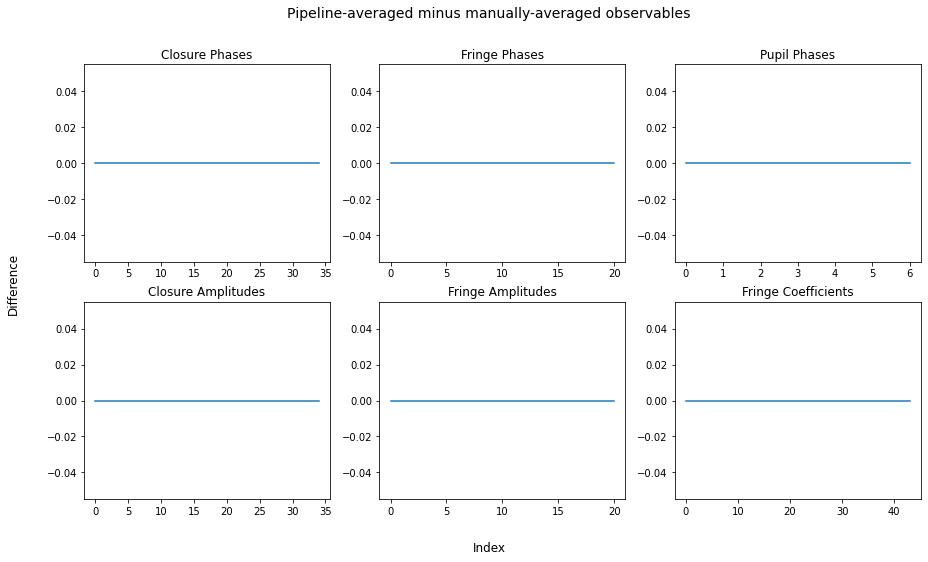

In [14]:
fig, axs = plt.subplots(2,3, figsize=(15,8))
plt.suptitle('Pipeline-averaged minus manually-averaged observables', size=14)
axs[0][0].plot(n_closure,CP_pipe - CP_man)
axs[0][0].set_title('Closure Phases')

axs[0][1].plot(n_fringe,FP_pipe - FP_man)
axs[0][1].set_title('Fringe Phases')

axs[0][2].plot(n_pup,PP_pipe - PP_man)
axs[0][2].set_title('Pupil Phases')

axs[1][0].plot(n_closure,CA_pipe - CA_man)
axs[1][0].set_title('Closure Amplitudes')

axs[1][1].plot(n_fringe,FA_pipe - FA_man)
axs[1][1].set_title('Fringe Amplitudes')

axs[1][2].plot(n_soln,soln_pipe - soln_man)
axs[1][2].set_title('Fringe Coefficients')

fig.text(0.5, 0.04, 'Index', ha='center', va='center', size=12)
fig.text(0.06, 0.5, 'Difference', ha='center', va='center', rotation='vertical', size=12)

<a id="about_ID"></a>
## About this Notebook
**Author:** Rachel Cooper, Science Support Analyst, ISSB/NIRISS
<br>**Updated On:** 07/19/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 